In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense

In [2]:
print(tf. __version__)

2.10.0


In [3]:
import os

# desktop
desktop_path = os.path.expanduser("~/Desktop")

# data file path
machine = os.path.join(desktop_path,"machine")
data_science = os.path.join(machine,"data_science")
rice_type_classification = os.path.join(data_science,"rice-type-classification")
data_file = os.path.join(rice_type_classification,"my_data/clusters.csv")

In [4]:
data = pd.read_csv(data_file)

In [5]:
# Custom rc definitions
rc = {
        'axes.spines.right': True,
        'axes.spines.top': True,
        'font.family': ['sans-serif'],
        'font.sans-serif':
        # 'Arial',
        'DejaVu Sans',
        # 'Liberation Sans',
        # 'Bitstream Vera Sans',
        # 'sans-serif',
        "xtick.bottom":True,
        'axes.edgecolor': 'indigo',
        'xtick.color': 'black',
        'figure.facecolor': "snow",
        'grid.color': 'grey',
        
}


# font definitions
font_label = {'family': 'serif',
        'color':  'darkred',
        'weight': 'semibold',
        'size': 16,
        }

font_title = {'family': 'serif',
        'color':  'black',
        'weight': 'semibold',
        'size': 16,
        }

font_fig = {'family': 'sans',
        'color':  'chocolate',
        # 'weight': 'bold', # doesn't apply to it. Must be specified independently
        # 'fontsize': 30, # doesn't apply to it. Must be specified independently
        }

In [6]:
data = pd.get_dummies(data,columns=['class'],drop_first=True)
data.head()

,area,majoraxislength,minoraxislength,eccentricity,convexarea,equivdiameter,extent,perimeter,roundness,aspectration,clusters,class_jasmine
0,6374,129.577,63.762,0.871,6476,90.087,0.662,314.656,0.809,2.032,3,1
1,6946,136.304,65.738,0.876,7115,94.042,0.594,338.782,0.761,2.073,1,1
2,5786,125.555,59.626,0.880,5945,85.831,0.623,307.304,0.770,2.106,3,1
3,5896,127.014,59.843,0.882,6092,86.643,0.610,309.264,0.775,2.122,3,1
4,6082,129.098,60.416,0.884,6204,87.999,0.661,308.106,0.805,2.137,3,1


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import  Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [8]:
X = data.drop(columns=["class_jasmine"])
y = data.class_jasmine

In [9]:
to_transform = ['area','majoraxislength','minoraxislength',
                'convexarea','equivdiameter','perimeter']

indexes = [ X.columns.tolist().index(value) for value in to_transform]
indexes

[0, 1, 2, 4, 5, 7]

In [10]:
# Scaler
scaler = StandardScaler()

# Column transformer
ct1 = ColumnTransformer([
    ('scale',scaler,indexes)],
    remainder='passthrough')

In [11]:
my_pipe = Pipeline([
    ("ct",ct1),
    # ('pca',PCA(n_components=6))
])

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=.20)

In [13]:
X_train_preprocessed = my_pipe.fit_transform(X_train)
X_test_preprocessed = my_pipe.transform(X_test)

In [14]:
pipeline_path = "pipeline"
os.makedirs(pipeline_path,exist_ok=True)

In [15]:
import pickle

with open('../pipeline/pipeline_classifier2.pkl','wb') as filer:
    pickle.dump(my_pipe,filer)

In [16]:
from tensorflow.keras.layers import Input,Add
from tensorflow.keras.models import Model

In [17]:
def residual_block(x):
    identity = x
    x = Dense(64,activation='relu',name="residual_block_layer_1")(x) # 64
    x = Dense(64,activation='relu',name="residual_block_layer_2")(x) # 64
    x = Add()([identity,x] )# 64 + 64 = 128

    return x

In [18]:
def custom_model(input_shape):
    inputs = Input(shape=(input_shape,),name='input_layer')
    x = Dense(64,activation='relu',name="layer1")(inputs)
    x = residual_block(x) # 128
    x = Dense(32,activation="relu",name="layer2")(x) 
    x = Dense(16,activation="relu",name="layer3")(x)
    x = Dropout(.7)(x)
    output_layer= Dense(1,activation="sigmoid",name="output")(x)
    model = Model(inputs=inputs,outputs=output_layer)

    return model


In [19]:
X_train_preprocessed.shape

(14117, 11)

In [20]:
X_train_preprocessed[:1]

array([[-1.28272086, -0.62321823, -1.36230057, -1.3339193 , -1.33254602,
        -1.2864855 ,  0.949     ,  0.457     ,  0.648     ,  3.166     ,
         3.        ]])

In [21]:
model = custom_model(X_test_preprocessed.shape[1])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 11)]         0           []                               
                                                                                                  
 layer1 (Dense)                 (None, 64)           768         ['input_layer[0][0]']            
                                                                                                  
 residual_block_layer_1 (Dense)  (None, 64)          4160        ['layer1[0][0]']                 
                                                                                                  
 residual_block_layer_2 (Dense)  (None, 64)          4160        ['residual_block_layer_1[0][0]'] 
                                                                                              

In [22]:
# Define the custom callback
class MyCustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(MyCustomCallback, self).__init__()

    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            val_loss = logs.get('val_loss') 
            loss = logs.get('loss')
            val_acc = logs.get('val_acc') 
            acc = logs.get('acc')
            if val_loss < 0.01:
                print(f"\nValidation loss is less than 0.01. \nStopping training.\n")
                self.model.stop_training = True
            # elif (loss <0.6) and (val_loss <= loss):
            #     print(f"\nValidation loss is less than loss: {loss} and loss is less than 0.6\nStopping training.\n")
            #     self.model.stop_training = True
            elif (val_acc > 0.99 ) or (val_loss <= 0.01):
                print(f"\nValidation loss is <= 0.01 or val_acc >= 0.99\nStopping training.\n")
                self.model.stop_training = True

my_callback = MyCustomCallback()

In [23]:
import datetime
class TimeCallback(tf.keras.callbacks.Callback):

    def on_epoch_begin(self,epoch, logs=None):
        print('Epoch: {}, begins at {}\n'.format(epoch, datetime.datetime.now().time()))

    def on_epoch_end(self,epoch, logs=None):
        print('Epoch: {}, ends at {}\n'.format(epoch, datetime.datetime.now().time()))

my_timer = TimeCallback()

In [24]:
# Learning Rate Schedulers
peak_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    mode= 'min',
    min_lr=0.00001
)

# Learning rate scheduler
def scheduler(epoch,lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

my_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
# optimizer
optimise = tf.keras.optimizers.Adam(learning_rate=0.01)
# losses
my_loss = tf.keras.losses.binary_crossentropy

# metrics
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

In [25]:
model.compile(optimizer=optimise,loss=my_loss,
            metrics=[
                "acc",precision,recall
            ])

In [26]:
tf.keras.backend.clear_session()
model_history = model.fit(X_train_preprocessed,y_train,
                        epochs=20,batch_size=16,validation_split=.20,
                        # steps_per_epoch=5,
                        callbacks=[my_callback,my_scheduler,
                        peak_callback,my_timer])

Epoch: 0, begins at 13:30:05.711670

Epoch 1/20
697/706 [============================>.] - ETA: 0s - loss: 0.1644 - acc: 0.9531 - precision: 0.9836 - recall: 0.9293Epoch: 0, ends at 13:30:12.002087

706/706 [==============================] - 6s 6ms/step - loss: 0.1641 - acc: 0.9531 - precision: 0.9838 - recall: 0.9291 - val_loss: 0.0503 - val_acc: 0.9834 - val_precision: 0.9904 - val_recall: 0.9777 - lr: 0.0100
Epoch: 1, begins at 13:30:12.010035

Epoch 2/20
697/706 [============================>.] - ETA: 0s - loss: 0.1196 - acc: 0.9644 - precision: 0.9905 - recall: 0.9437Epoch: 1, ends at 13:30:15.343825

706/706 [==============================] - 3s 5ms/step - loss: 0.1197 - acc: 0.9642 - precision: 0.9906 - recall: 0.9432 - val_loss: 0.0591 - val_acc: 0.9873 - val_precision: 0.9827 - val_recall: 0.9933 - lr: 0.0100
Epoch: 2, begins at 13:30:15.356786

Epoch 3/20
699/706 [============================>.] - ETA: 0s - loss: 0.1464 - acc: 0.9534 - precision: 0.9900 - recall: 0.9239Epoch:

In [27]:
score = model.evaluate(X_test_preprocessed,y_test,verbose=1)

111/111 [==============================] - 0s 3ms/step - loss: 0.0456 - acc: 0.9904 - precision: 0.9882 - recall: 0.9943


In [28]:
# # Model Performance Charts original

# plt.plot(model_history.history['acc'])
# plt.plot(model_history.history['val_acc'])

# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['training','validation'], loc='upper left')
# plt.show()

# plt.plot(model_history.history['loss'])
# plt.plot(model_history.history['val_loss'])

# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['training','validation'], loc='upper left')
# plt.show()

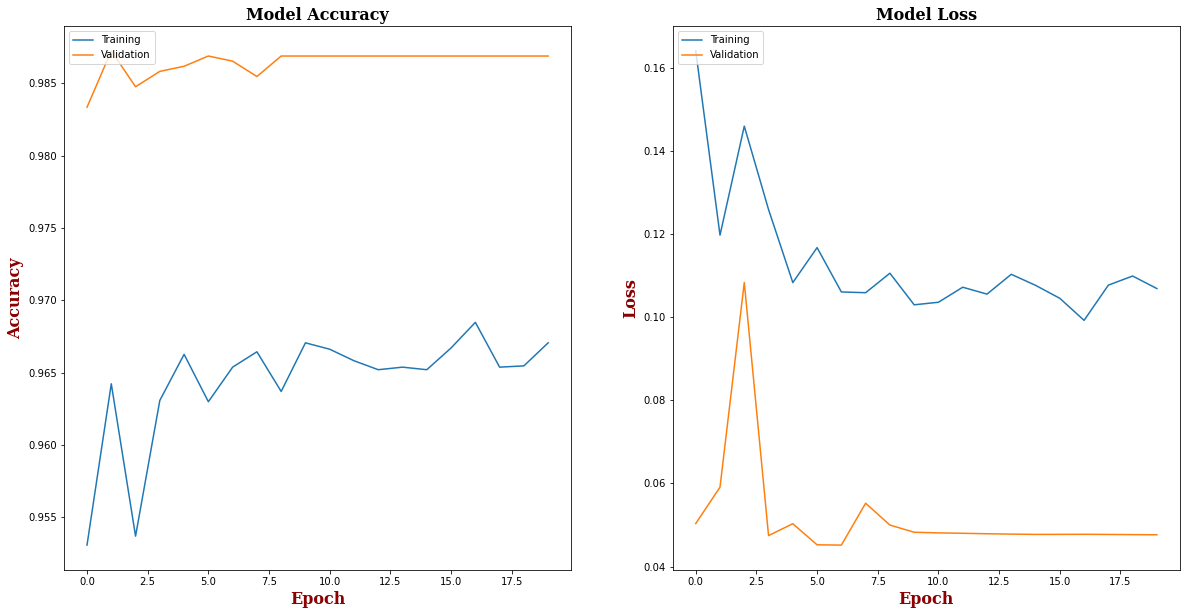

In [29]:
# Model Performance Charts
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot accuracy
ax[0].plot(model_history.history['acc'])
ax[0].plot(model_history.history['val_acc'])
ax[0].set_title('Model Accuracy',fontdict=font_title)
ax[0].set_ylabel('Accuracy',fontdict=font_label)
ax[0].set_xlabel('Epoch',fontdict=font_label)
ax[0].legend(['Training', 'Validation'], loc='upper left')

# Plot loss
ax[1].plot(model_history.history['loss'])
ax[1].plot(model_history.history['val_loss'])
ax[1].set_title('Model Loss',fontdict=font_title)
ax[1].set_ylabel('Loss',fontdict=font_label)
ax[1].set_xlabel('Epoch',fontdict=font_label)
ax[1].legend(['Training', 'Validation'], loc='upper left')

# Show the plots
plt.show()


### **Classification report**

442/442 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6485
           1       0.99      0.99      0.99      7632

    accuracy                           0.99     14117
   macro avg       0.99      0.99      0.99     14117
weighted avg       0.99      0.99      0.99     14117



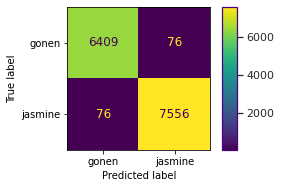

In [30]:
from sklearn.metrics import classification_report,\
    confusion_matrix, ConfusionMatrixDisplay

def class_report(model,X,y_true):
    y_pred_proba  = model.predict(X)
    # Convert probabilities to binary predictions
    y_pred = (y_pred_proba > 0.5).astype(int)
    fig,ax = plt.subplots(1, figsize=(5,2.5),constrained_layout=True)
    sns.set_theme(style='white',rc=rc,palette='bright')
    print(classification_report(y_true,y_pred ))
    cm = confusion_matrix(y_true,y_pred ,labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                        display_labels=['gonen','jasmine'])
    disp.plot(ax=ax)
    plt.show()

class_report(model,X_train_preprocessed,y_train)

111/111 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1599
           1       0.99      0.99      0.99      1931

    accuracy                           0.99      3530
   macro avg       0.99      0.99      0.99      3530
weighted avg       0.99      0.99      0.99      3530



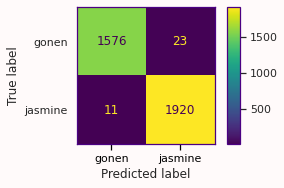

In [31]:
# test data
class_report(model,X_test_preprocessed,y_test)

111/111 [==============================] - 0s 2ms/step


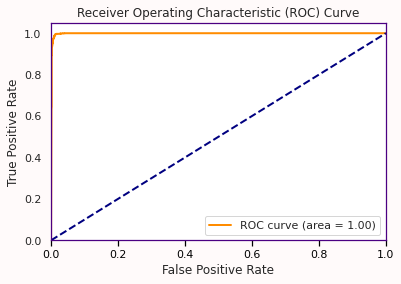

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Make predictions on test data
y_pred = model.predict(X_test_preprocessed)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [33]:
model_path = "model"
os.makedirs(model_path,exist_ok=True)

In [35]:
# model = os.path
model.save(f"../{model_path}/deep_classifier2")

INFO:tensorflow:Assets written to: model/deep_classifier2\assets
